<a href="https://colab.research.google.com/github/zivdar001matin/nma-project/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import signal
import scipy.io

!pip install mne --quiet

import mne
from mne import create_info, EpochsArray
from mne.io import RawArray
from mne.baseline import rescale
from mne.time_frequency import (tfr_multitaper, tfr_stockwell, tfr_morlet, tfr_array_morlet)
from mne.viz import centers_to_edges

from matplotlib import colors
from matplotlib import rcParams
from matplotlib import pyplot as plt

# Load Data

In [ ]:
#@title Data retrieval
import os, requests

fname = 'joystick_track.npz'
url = "https://osf.io/6jncm/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

Select subject 0

In [ ]:
# Select just one of the recordings here. This is subject 1, block 1.
dat = alldat[0][0]

print(dat.keys())

targetX = dat['targetX']
targetY = dat['targetY']
cursorX = dat['cursorX']
cursorY = dat['cursorY']

# Separate Blocks

Find each block idx

In [ ]:
# sum = 0
# idxs = []
# for i in range(len(df_task.TargetPosX)):
#     if df_task.TargetPosX[i] < 200:
#         sum +=1
#         if sum == 1:
#             idxs.append(i)
#     else:
#         sum = 0

# Figured out manually for the subject_0 using `plotly`
idxs = np.array([
    [2200, 62159],
    [64320, 124279],
    [126440, 186440],
    [188560, 248560],
    [250680, 310680],
    [312800, 372759]
])

In [ ]:
np.diff(idxs)

In [ ]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(dat['targetX'])
plt.vlines(idxs[:, 0], 0, 30000, color='red')
plt.vlines(idxs[:, 1], 0, 30000, color='green')

Trajectory Shape

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)
plt.scatter(dat['targetX'][dat['targetX'] > 1000],dat['targetY'][dat['targetY'] > 1000])

# Loss

In [ ]:
print(np.min(targetX[targetX > 1000]), np.min(targetY[targetY > 1000]))
print(np.max(targetX[targetX > 1000]), np.max(targetY[targetY > 1000]))
min = np.min(targetX[targetX > 1000])
max = np.max(targetX[targetX > 1000])
center = np.mean([min, max])
radius = max - center

print(center, radius)

Calculate the loss using distance to the circle


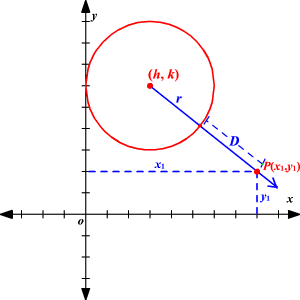

$|\sqrt{(x - x_c)^2 + (y - y_c)^2} - r|$

In [ ]:
def distance_to_circle(X, Y, x_c, y_c, r):
    return np.abs(np.sqrt((X-x_c)**2 + (Y-y_c)**2) - r)

In [ ]:
def normalize_error(error):
    return (error - np.min(error))/(np.max(error) - np.min(error))

In [ ]:
def plot_error(error, idxs=None, averaging=False):
    plt.rcParams["figure.figsize"] = (20,3)
    # Normalize the error
    error = normalize_error(error)
    if averaging is False:
        loop_error = error
        if idxs is not None:
            plt.vlines(idxs[:, 0], -0.1, 1.1, color='red')
            plt.vlines(idxs[:, 1], -0.1, 1.1, color='green')
    else:
        loop_error = []
        for i in range(len(error)//6200):
            loop_error.append(np.mean(error[int(i*6200):int((i+1)*6200)]))
        if idxs is not None:
            plt.vlines(idxs[:, 0]/6200, 0, 1, color='red')
            plt.vlines(idxs[:, 1]/6200, 0, 1, color='green')

    plt.plot(loop_error)


In [ ]:
error = distance_to_circle(cursorX, cursorY, center, center, radius)
plot_error(error, idxs)

(using the notebook provided [here](https://colab.research.google.com/drive/1q3AloIhVCohWlb09919lpmiDFSDsb0Yi?usp=sharing))
# ECoG time-frequency analysis

Pipeline:

(A) Filter data twice
  - 3rd Order Butterworth High-Pass Filter (Cutoff at 1 Hz)
  - 3rd Order Butterworth Low-Pass Filter (Cutoff at 200 Hz)

(B) Set epoch window and categories
  - Epoch window size: 2000 Samples
  - Epochs & power for 4 categories:
    1. Tongue Real
    2. Hand Real
    3. Tongue Imagined
    4. Hand Imagined

(C) Wavelet analysis
  - Morlet wavelet analysis specifications:
    1. Frequency Range: 5 - 80 Hz
    2. Cycles: 2

(D) Spectrograms
  - Average power spectrum across all channels
  - Average and combine frequencies within specific bands (Alpha, Beta, Gamma)

  NOTE:
  The Time-Freq Analysis used here is the Morlet Wavelet Transform. This type of analysis can identify different frequency bands in ECoG signals, track the temporal dynamics, and study the interactions between different frequency bands.  It yields both temporal and spectral characteristics of the signal.

In [ ]:
# @title  Select electrodes of interest (Pre- and Post-central Gyrus)

# this is for all subjects

electrode_roi = []

# Iterate for Each Subject
for subject_index, subject in enumerate(alldat[0]):

  electrode_indexes_precentral = []
  electrode_indexes_postcentral = []

  for gyrus_index, gyrus in enumerate(subject['gyrus']):
    if gyrus == 'Precentral Gyrus':
      electrode_indexes_precentral.append(gyrus_index)
    elif gyrus == 'Postcentral Gyrus':
      electrode_indexes_postcentral.append(gyrus_index)

  electrode_roi.append(electrode_indexes_precentral + electrode_indexes_postcentral)

  print('\033[1m' + 'Subject {}:'.format(subject_index) + '\033[0m' + """\n  Precentral Gyrus: {}\n  Postcentral Gyrus: {}""".format(electrode_indexes_precentral,electrode_indexes_postcentral))

In [ ]:
# @title Time-Frequency Analysis of All Subjects

# Number of Subjects
subject_count = alldat.shape[1]

# TODO increase window to fit each training block (if it's set to actuall value kernel will crash)
# window = 59959
window = 30000

# Instantiate Empty Array for All Subjects' Tongue & Hand Epochs
freqs = np.arange(3., 80., 2.)                # (lower bound of freq range, upper bound of freq range, bin size)
power = np.ones((subject_count, len(freqs), window))    # 3D array that stores the power spectrum with ((subject number, freq bin, time bin))

# Instantiate Empty Array for All Subjects' Tongue & Hand Band-Specific Power (Alpha Beta Gamma)
power_theta = np.ones((subject_count, window))
power_alpha = np.ones((subject_count, window))
power_beta = np.ones((subject_count, window))
power_gamma = np.ones((subject_count, window))

# Iterate for Each Subject
for isub in range(subject_count):                                         # for each subject and condition, extract voltage data, filter it, take epochs, then

  # TODO for other subjects
  if isub != 0:
    continue

  dat = alldat[0][isub]

  # Extract Continuous Voltage Data & Assign Proper Type
  volt_data = dat['V'].astype('float32')
  chan_used = electrode_roi[isub]
  volt_data = volt_data[:, chan_used]

  # Multiply with Scale to Calculate uV Values
  # volt_data = volt_data * block['scale_uv']

  # 3rd Order Butterworth Filter (High-pass 1Hz)
  b, a = signal.butter(3, [1], btype='high', fs=1000)
  volt_data = signal.filtfilt(b, a, volt_data, 0)

  # 3rd Order Butterworth Filter (Low-pass 200Hz)
  b, a = signal.butter(3, [200], btype='low', fs=1000)
  volt_data = signal.filtfilt(b, a, volt_data, 0)

  # Extract {window} ms after Stimulus Onset for All Stimulus (~60 Total), Creating Epochs-Array
  epoch_window = np.arange(0, window)
  epoch_timepoints = idxs[:, 0][:, np.newaxis] + epoch_window          # an epoch is time-locked to the stimulus onset (tongue and hand stim)

  # Transpose Data to Match MNE Epochs Object Input Dimension (Credits to Xianhui)
  V_epochs_combined = volt_data[epoch_timepoints, :].transpose((0,2,1)) # epoch * chan * time
                                                      # Note: MNE Epochs object is a class in the MNE library used to store and manipulate epochs of data
                                                      # after transpose, axis0 = epoch index; axis1 = chan index; axis2 = time index

  # Separate Epochs Between Tongue & Hand
  # V_epochs_tongue = (V_epochs_combined[dat['stim_id'] == 11, :, :])
  # V_epochs_hand = (V_epochs_combined[dat['stim_id'] == 12, :, :])
  V_epochs = V_epochs_combined

  # obtain each channel's power
  # (n_epochs, n_chans, n_freqs, n_times)
  _power = tfr_array_morlet(V_epochs, 1000, freqs, n_cycles=2, output='power', verbose='WARNING')

  # Normalize power
  # calculate the mean power of each frequency and each channel [n_chan, n_fre]
  mean_power = np.mean(np.mean(_power, 3), 0)

  mean_matrix = np.ones((6, len(chan_used), len(freqs), window))

  # construct mean power matrix                           # mean power matrix is a matrix that contains the mean power for each channel and frequency band
  for iitrial in range(6):
    for iitime in range(window):
      mean_matrix[iitrial, :, :, iitime] = mean_power

  _power = _power / mean_matrix        # divide the power spectra by the mean power matrix for each condition

  a = np.mean(_power, 0)                            # calculate the mean power (averaged power across all channels and time points) per condition

  # (n_subs, n_freqs, n_times)                            # calculate the mean power for tongue and hand epochs accdg to alpha, beta, & gamma bands
  power[isub, :, :] = np.mean(np.mean(_power, 0), 0)

  # Split into Bands
  power_theta[isub, :] = np.mean(power[isub,:3,:],0)
  power_alpha[isub, :] = np.mean(power[isub,3:5,:],0)
  power_beta[isub, :] = np.mean(power[isub,5:14,:],0)
  power_gamma[isub, :] = np.mean(power[isub,14:39,:],0)

## Time-Frequency Analysis Averaged and Plotted


1. Spectogram
2. Band-Specific Activities
3. Spectogram Difference

In [ ]:
# @title Average Across 7 Subjects

# Calculate Grand Average of Power Across Subjects
power_all = np.mean(power, 0)

# Convert Power GA to Log Power
power_all = 10 * np.log10(power_all)

# Calculate Grand Average of Band Power Across Subjects
power_theta_all = np.mean(power_theta, 0)

power_alpha_all = np.mean(power_alpha, 0)

power_beta_all = np.mean(power_beta, 0)

power_gamma_all = np.mean(power_gamma, 0)

In [ ]:
# @title Spectogram of All 4 Categories


# Plot All 4 Power Data
f, ax = plt.subplots(figsize=(9,6))
time_range=range(window)

c1 = ax.pcolor(time_range, freqs, power_all, cmap='viridis')      # also try cmap='RdBu_r'
ax.set_title("")
ax.set_xlabel('time (ms)')
ax.set_ylabel('frequency (Hz)')
f.colorbar(c1, ax=ax)

plt.tight_layout()
title = "Time-Frequency Analysis"
plt.suptitle(title, x=0.5, y=1.1)
plt.show()

In [ ]:
e_window = np.arange(0, window)
e_timepoints = idxs[:, 0][:, np.newaxis] + epoch_window          # an epoch is time-locked to the stimulus onset (tongue and hand stim)
e_epoch_combined = error[epoch_timepoints, :].transpose((0,2,1))

In [ ]:
# @title Band Power Spectra (Alpha, Beta, Gamma)

f, axes = plt.subplots(5, 1, figsize=(24, 24))
time_range=range(window)

# Plot Band Activities

ax1 = axes[0]
ax1.plot(time_range,power_theta_all, label='')
ax1.set_title("Theta Band (4-8 Hz)")
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('Power')
# ax1.legend()

ax2 = axes[1]
ax2.plot(time_range,power_alpha_all, label='')
ax2.set_title("Alpha Band (8-12 Hz)")
ax2.set_xlabel('time (ms)')
ax2.set_ylabel('Power')
# ax2.legend()

ax3 = axes[2]
ax3.plot(time_range,power_beta_all, label='')
ax3.set_title("Beta Band (12-30 Hz)")
ax3.set_xlabel('time (ms)')
ax3.set_ylabel('Power')
# ax3.legend()

ax4 = axes[3]
ax4.plot(time_range,power_gamma_all, label='')
ax4.set_title("Gamma Band (30-100 Hz)")
ax4.set_xlabel('time (ms)')
ax4.set_ylabel('Power')
# ax4.legend()

ax5 = axes[4]
ax5.plot(time_range,normalize_error(np.mean(e_epoch_combined, 0)[0]), label='')
ax5.set_title("Circullar Loss")
ax5.set_xlabel('time (ms)')
ax5.set_ylabel('Normalized loss')
# ax5.legend()
